# Twitter Sentiment Analysis #

Importing required libraries

In [36]:
import tweepy
import pandas as pd
import numpy as np
import re
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Setting up connection to Twitter API

In [2]:
api_key='xxxxxxxxxxx'
api_secret_key='xxxxxxxxxxxxxxx'
bearer_token='xxxxxxxxxxxxxxx'

In [4]:
authentication = tweepy.AppAuthHandler(api_key, api_secret_key)
twitter = tweepy.API(authentication)

In [ ]:
#results = twitter.search(q='Sentiment')

Importing the Training dataset

In [2]:
dataset = pd.read_csv('NoThemeTweets.csv')
dataset.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1031761728445530112,@Tixaa23 14 para eu ir :),Tue Aug 21 04:35:39 +0000 2018,Positivo,:)
1,1031761040462278656,@drexalvarez O meu like eu já dei na época :),Tue Aug 21 04:32:55 +0000 2018,Positivo,:)
2,1031760962372689920,Eu só queria conseguir comer alguma coisa pra ...,Tue Aug 21 04:32:37 +0000 2018,Positivo,:)
3,1031760948250456066,:D que lindo dia !,Tue Aug 21 04:32:33 +0000 2018,Positivo,:)
4,1031760895985246208,"@Primo_Resmungao Pq da pr jeito!!é uma ""oferta...",Tue Aug 21 04:32:21 +0000 2018,Positivo,:)


In [3]:
sentiments = dataset.sentiment.value_counts()
print('Class ratio:', sentiments['Positivo']/sentiments['Negativo'])
sentiments

Class ratio: 0.5033546518412801


Negativo    522707
Positivo    263107
Name: sentiment, dtype: int64

In [4]:
#removing duplicated entries
dataset = dataset[~dataset.index.duplicated(keep='first')]

In [5]:
dataset.shape

(785814, 5)

In [6]:
#removing unwanted columns
del dataset['id']
del dataset['tweet_date']
del dataset['query_used']

In [7]:
dataset.shape

(785814, 2)

In [8]:
dataset.rename({'tweet_text':'text'}, axis=1, inplace=True)

In [9]:
dataset.head()

,text,sentiment
0,@Tixaa23 14 para eu ir :),Positivo
1,@drexalvarez O meu like eu já dei na época :),Positivo
2,Eu só queria conseguir comer alguma coisa pra ...,Positivo
3,:D que lindo dia !,Positivo
4,"@Primo_Resmungao Pq da pr jeito!!é uma ""oferta...",Positivo


Declaring required functions

In [10]:
#Pre processing: removing URLs, @, # and punctuations; removing stopwords

def preprocess(tweet):
    tweet.lower()
    
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stopwords
    tokens = word_tokenize(tweet)
    filtered_tweet = [w for w in tokens if not w in stop_words]
    
    return " ".join(filtered_tweet)

In [11]:
#Creating feature vector

def get_feature_vector(training_set):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(training_set)
    return vector

In [34]:
def word_cloud(wd_list, stop_words):
    stopwords = set(stop_words)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=21,
        colormap='jet',
        max_words=50,
        max_font_size=200).generate(all_words)

    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");

Main code

In [12]:
#defining stop words to be removed during pre-processing
stop_words = set(stopwords.words('portuguese'))

In [13]:
#pre-process the tweets
dataset.text = dataset['text'].apply(preprocess)

In [14]:
#check the results after pre-processing
dataset.head()

,text,sentiment
0,14 ir,Positivo
1,O like dei época,Positivo
2,Eu queria conseguir comer alguma coisa pra pod...,Positivo
3,D lindo dia,Positivo
4,Pq pr jeitoé oferta ha q aproveitar P,Positivo


In [15]:
#vectorizing the data and separating the tweets to be analyzed and the sentiments
tf_vector = get_feature_vector(np.array(dataset.iloc[:, 0]).ravel())
x = tf_vector.transform(np.array(dataset.iloc[:, 0]).ravel()) #tweets
y = np.array(dataset.iloc[:, 1]).ravel() #target - sentiments

In [16]:
#check the results after vectorizing process
print(x.shape)
print(y.shape)
print(x[0])
print(y[0])

(785814, 196649)
(785814,)
  (0, 101643)	0.4994312595342391
  (0, 1662)	0.8663535173357604
Positivo


In [17]:
#splitting up the dataset into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [19]:
#training Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(x_train, y_train)
y_predict_nb = NB_model.predict(x_test)

print(accuracy_score(y_test, y_predict_nb))

0.7733181474011058


In [20]:
#saving Naive Bayes model
pickle.dump(NB_model,open("NB_model.pkl","wb"))

In [21]:
#training Logistics Regression model
LR_model = LogisticRegression(solver='sag')
LR_model.fit(x_train, y_train)
y_predict_lr = LR_model.predict(x_test)

print(accuracy_score(y_test, y_predict_lr))

0.8001247112870078


In [22]:
#saving Logistics Regression model
pickle.dump(LR_model,open("LR_model.pkl","wb"))

In [23]:
#training Support Vector Classification model
LinearSVC_model = LinearSVC()
LinearSVC_model.fit(x_train, y_train)
y_predict_svc = LinearSVC_model.predict(x_test)

print(accuracy_score(y_test, y_predict_svc))

0.7933737584545981


In [24]:
#saving SVC model
pickle.dump(LinearSVC_model,open("LinearSVC_model.pkl","wb"))

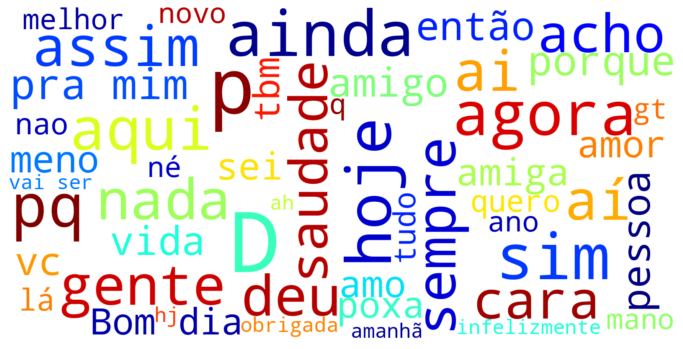

In [37]:
word_cloud(list(dataset['text']), stop_words)